In [1]:
import os, sys

In [2]:
base_dir = os.path.split(os.getcwd())[0]
os.chdir(os.path.join(base_dir))
sys.path.append("core")

In [3]:
import pickle as pk

import numpy as np
import cv2
import sys
import argparse
import time
import copy
import datetime
import yaml

import matplotlib.pyplot as plt

from utils import ARUCO_DICT, display_pose
from estimators import PoseSingle

In [11]:
k_matrix = "calib/calibration_matrix_hikvision.npy"
d_coeff = "calib/distortion_coefficients_hikvision.npy"
config_filename = "jupyters/marker_poses.yaml"

edge_len = 0.7
marker_step = 10
n_markers = 100

type_ = "DICT_5X5_100"

if ARUCO_DICT.get(type_, None) is None:
    print(f"ArUCo tag type '{type_}' is not supported")
    sys.exit(0)

aruco_dict_type = ARUCO_DICT[type_]
calibration_matrix_path = k_matrix
distortion_coefficients_path = d_coeff

k = np.load(k_matrix)
d = np.load(d_coeff)


with open(config_filename, encoding='utf8') as f:
    cfg = yaml.load(f, Loader=yaml.FullLoader)

marker_poses = dict(
    zip([id for id in range(len(cfg['poses']))], 
        cfg['poses']))

# Изменим калибровки так как разрешение потока отличается от разрешения калибровочного видео
k_video = copy.deepcopy(k)
k_video[0,0] = k_video[0,0] * 1280/2688
k_video[1,1] = k_video[1,1] * 720/1520

k_video[0,2] = k_video[0,2] * 1280/2688
k_video[1,2] = k_video[1,2] * 720/1520

In [12]:
estimator_front = PoseSingle(
    aruco_dict_type,
    -1,
    n_markers,
    marker_poses,
    edge_len,
    k_video,
    d,
    apply_kf = True,
    transition_coef = 50,
    observation_coef = 0.02,
    x_bias = 1.25,
    # left_edge_weight_func  = f_left_x_04,
)

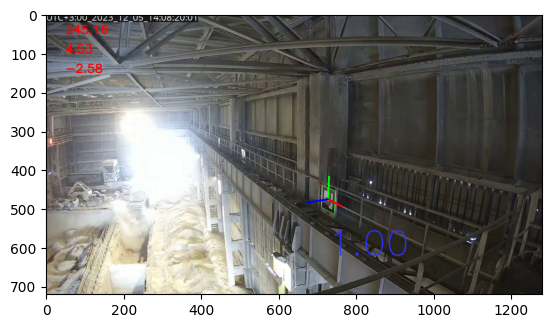

[[0.4595580470856102 0.17616828809027846 -0.8705005086903745
  245.15877173943355]
 [-0.8879765501857773 0.07189508171065978 -0.45423423863243023
  4.533379010045605]
 [-0.017436963010400874 0.9817310382671816 0.18947327205655073
  -2.5806311336672487]
 [0.0 0.0 0.0 1.0]]


In [13]:
# Test on single image
image = "D:\\NKB\\cranepos_data\\frames4\\100.png"

image = cv2.imread(image)
time.sleep(.1)

# output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plt.imshow(output)
# plt.show()

frame, pose, size = estimator_front(image, True)

output = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)

output = display_pose(output, pose[:-1,[3]])

plt.imshow(output)
plt.show()
print(pose)

In [ ]:
# Test on multiple images
for i in range(318,320):
    print(i)
    image = cv2.imread(f"../data/hikvision/demo1/frames_f/{i}.png")
    time.sleep(.1)
    
    # output = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # plt.imshow(output)
    # plt.show()
    
    frame, pose, dt, size = estimator(image, "now", True)
    
    output = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    try:
        output = display_pose(output, pose[:-1,[3]])
    except: continue
    plt.imshow(output)
    plt.show()
    print(pose)
    

In [ ]:
frame.shape

In [ ]:
# Alter intrinsic matrix with resolutoin change
k_video = copy.deepcopy(k)
k_video[1,1] = k_video[1,1] * 720/960

# or

k_video = k

In [ ]:
# np.save("camera_matrix_video.npy", k_video)

In [ ]:
cap = cv2.VideoCapture('../data/hikvision/demo1/r.mp4')

In [ ]:
width  = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
fps = int(cap.get(cv2.CAP_PROP_FRAME_COUNT)/10)
length = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

estimator_video = PoseSingle(
    aruco_dict_type,
    n_markers,
    marker_step,
    edge_len,
    k,
    d
)

out = cv2.VideoWriter('../data/results/hikvision_r_weighted_flip.mov', cv2.VideoWriter_fourcc('M','J','P','G'), 30, (width,height))

In [ ]:
if (cap.isOpened()== False): 
  print("Error opening video stream or file")

while(cap.isOpened()):
    # Capture frame-by-frame
    ret, frame = cap.read()
    if ret == True:
        frame, pose, dt, size = estimator_video(frame, "now", True)
        # print(type(pose))
        output = frame#cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
        # print(pose.shape==())
        if pose.shape!=():
            output = display_pose(output, pose[:-1,[3]])
        
        out.write(output)
  # Break the loop
    else: 
        break

cap.release()
out.release()

In [ ]:
frame